<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/TimeSeries_Seq_2_Seq/Seq2Seq_Multi_Selection_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Chargement et correction des données

**1. Chargement des données**

In [ ]:
!rm *.csv
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Seq2Seq/Data/Power_PV.csv"

**2. Analyse et correction des données**

In [ ]:
# Création de la série sous Pandas
df_data = pd.read_csv("Power_PV.csv")
df_data

Affiche les types :

In [ ]:
df_data.dtypes

Converison des types `object` en `float32` :

In [ ]:
df_data.iloc[:,1:] = pd.DataFrame.replace(df_data.iloc[:,1:],"?","NaN")
df_data.iloc[:,1:] = df_data.iloc[:,1:].astype(np.float32)
df_data

In [ ]:
df_data.dtypes

In [ ]:
# Définition des dates de début et de fin

date_debut = "2018-07-01 00:00:00"
date_fin = "2019-04-14 00:00:00"

# Place l'index du dataframe sur la colonne Date
df_data = df_data.rename(columns={'Unnamed: 0': "Date"})
df_data = df_data.set_index(df_data['Date'])

# Copie des données dans le dataframe d'étude sur l'intervalle d'étude
df_etude = df_data.loc[date_debut:date_fin].copy()

# Conversion de la colonne Date au format datetime
df_etude.index = pd.to_datetime(df_etude.index)

# Suppression de la colonne Unnamed:0
df_etude = df_etude.drop("Date", axis=1)
df_etude

Vérification des données et correction des anomalies :

In [ ]:
np.sum(np.isnan(df_etude.iloc[:,1:]))

In [ ]:
df_etude = df_etude.fillna(method="backfill")

In [ ]:
np.sum(np.isnan(df_etude.iloc[:,1:]))

**5. Affiche les données**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_etude.index,y=df_etude['watts'], line=dict(color='blue', width=1),name="Puissance (W)"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Corrélations entre les variables

**1. Corrélation de l'ensemble des variables**

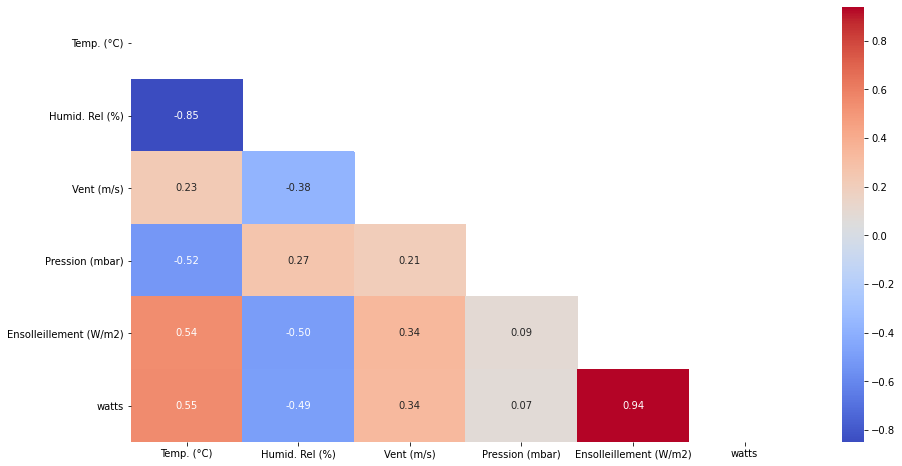

In [ ]:
import seaborn as sns

corr = df_etude.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

On remarque que la puissance est fortement corrélé avec :
- L'ensoleillement
- La température
- L'humidité relative

Par ailleurs, la puissance est très faiblement corrélée avec l'humidité relative. On peut donc envisager de garder l'ensoleillement, la température et l'humidité relative,  et de retirer la pression.

**2. Corrélation entre les variables restantes**

Regardons maintenant les corrélations entre les variables restantes :

In [ ]:
df_etude.iloc[:,-1:]

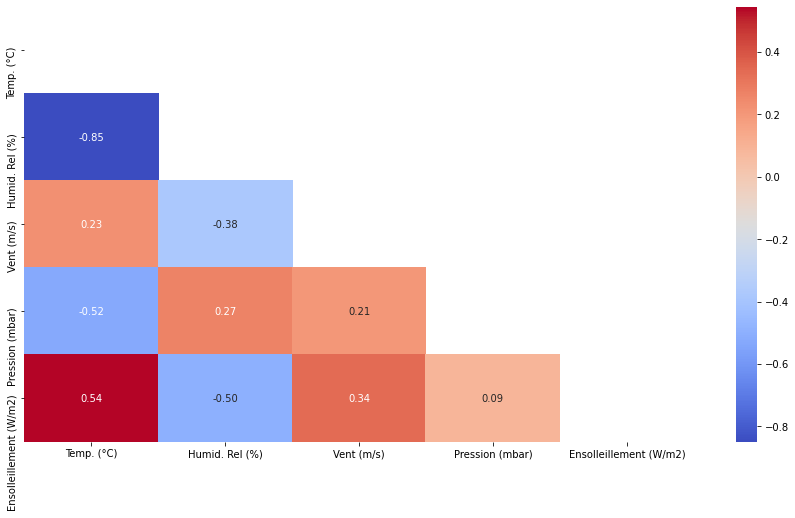

In [ ]:
import seaborn as sns

corr = df_etude.iloc[:,:-1].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

On remarque que l'ensoleillement est très corrélé avec l'humidité relative. On peut donc envisager de supprimer l'un des deux.  
On peut par exemple essayer de garder :
- L'ensoleillement
- La température

# Identification des variables les plus importantes par Random Forest

**1. Création des données X et Y**

In [ ]:
X = df_etude.iloc[:,0:-1]
X

,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2)
Date,,,,,
2018-07-01 00:00:00,18.230667,78.229332,1.434800,930.0,0.0
2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0
2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0
2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0
2018-07-01 01:00:00,18.384001,77.567337,1.409467,930.0,0.0
...,...,...,...,...,...
2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0
2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0
2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0


In [ ]:
Y = df_etude.iloc[:,-1:]
Y

,watts
Date,
2018-07-01 00:00:00,0.0
2018-07-01 00:15:00,0.0
2018-07-01 00:30:00,0.0
2018-07-01 00:45:00,0.0
2018-07-01 01:00:00,0.0
...,...
2019-04-13 23:00:00,0.0
2019-04-13 23:15:00,0.0
2019-04-13 23:30:00,0.0


**1. Choix du nombre d'arbres**

On commence par regarder comment évolue le score sur une 10ène d'essais avec un nombre d'arbres croissant :

In [ ]:
# Informations sur les données
n = 27553             # Nombre d'observations
p = 5                 # Nombre de variables

n_arbres_max = 500

n_arbres = np.linspace(50,n_arbres_max,10).astype(np.int32)
mtry = np.sqrt(p).astype(np.int32)
OOB_err = []

for i in n_arbres:
  print("#Arbres : %d" %i)
  clf = RandomForestRegressor(n_estimators=i, bootstrap=True, oob_score=True, max_samples = n, max_features = mtry, n_jobs=-1)
  clf.fit(X,tf.squeeze(np.asarray(Y),1))
  OOB_err.append(1 - clf.oob_score_)

#Arbres : 50
#Arbres : 100
#Arbres : 150
#Arbres : 200
#Arbres : 250
#Arbres : 300
#Arbres : 350
#Arbres : 400
#Arbres : 450
#Arbres : 500


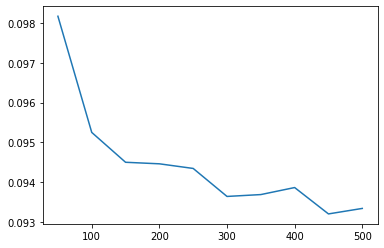

In [ ]:
plt.plot(n_arbres,OOB_err)

On choisir n_arbres = 500 et on utilise m_try = 5

# Importance des variables - Pemière approche : Importance sans permutations

**1. Entrainement de la forêt**

In [ ]:
from sklearn.inspection import permutation_importance

# Informations sur les données
n = 27553             # Nombre d'observations
p = 5                 # Nombre de variables
n_arbres = 500
m_try = 5

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
clf.fit(X,tf.squeeze(np.asarray(Y),1))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

**2. Affichage de l'importance des variables**

In [ ]:
col_sorted_by_importance=clf.feature_importances_.argsort()
feat_imp = pd.DataFrame({'cols':X.columns[col_sorted_by_importance],'imps':clf.feature_importances_[col_sorted_by_importance]})
feat_imp

,cols,imps
0,Pression (mbar),0.013912
1,Vent (m/s),0.020009
2,Humid. Rel (%),0.027583
3,Temp. (°C),0.027701
4,Ensolleillement (W/m2),0.910795


In [ ]:
!pip install plotly_express --upgrade -q

In [ ]:
import plotly_express as px
import plotly.offline as po

px.bar(feat_imp.sort_values(['imps'], ascending=False)[:30], x='cols', y='imps', labels={'cols':'column', 'imps':'feature importance'})

# Importance des variables - Deuxième approche : Méthode par permutations des importances

Permutation importance is a technique where we shuffle the values of a single column and run the model to see how the scores get affected. If the scores are affected greatly, then the feature is highly important to the model and if not, it does not add significant value to the model.

Let us see the feature importances for recall score on the test dataset.

In [ ]:
import random

def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
    bar=progressbar.ProgressBar(max_value=len(X.columns))
    baseline_metric=clf.score(X,y)
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
            score = clf.score(X1,y)
            scores[c].append(baseline_metric-score)
        bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import progressbar

baseline, scores = PermImportance(X, tf.squeeze(np.asarray(Y),1), clf, recall_score, num_iterations=10)

 80% (4 of 5) |####################      | Elapsed Time: 0:00:14 ETA:   0:00:03

In [ ]:
percent_changes={c:[] for c in X.columns}
for c in scores:
    for i in range(len(scores[c])):
        percent_changes[c].append(scores[c][i]/baseline*100)

In [ ]:
pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)

,variable,value
0,Ensolleillement (W/m2),171.007927
3,Temp. (°C),10.140966
1,Humid. Rel (%),7.921568
2,Pression (mbar),4.349316
4,Vent (m/s),3.531353


In [ ]:
px.bar(
    pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False),
    x='variable',y='value',labels={'variable':'column','value':'% change in recall'})

# Comparaison entre les deux méthodes

In [ ]:
# Calcul des écarts-types et des moyennes
scores_std = {}
scores_mean = {}
for element in scores:
  scores_std[element] = np.std(scores[element])
  scores_mean[element] = np.mean(scores[element])

df_perm = pd.DataFrame.from_dict([scores_std, scores_mean]).transpose()
df_perm = df_perm.rename(columns={0:"std",1:"mean"})
df_perm = df_perm.sort_values(by=['mean'],ascending=False)
df_perm

,std,mean
Ensolleillement (W/m2),0.010178,1.687422
Temp. (°C),0.000921,0.100066
Humid. Rel (%),0.000844,0.078166
Pression (mbar),0.000465,0.042917
Vent (m/s),0.000327,0.034846


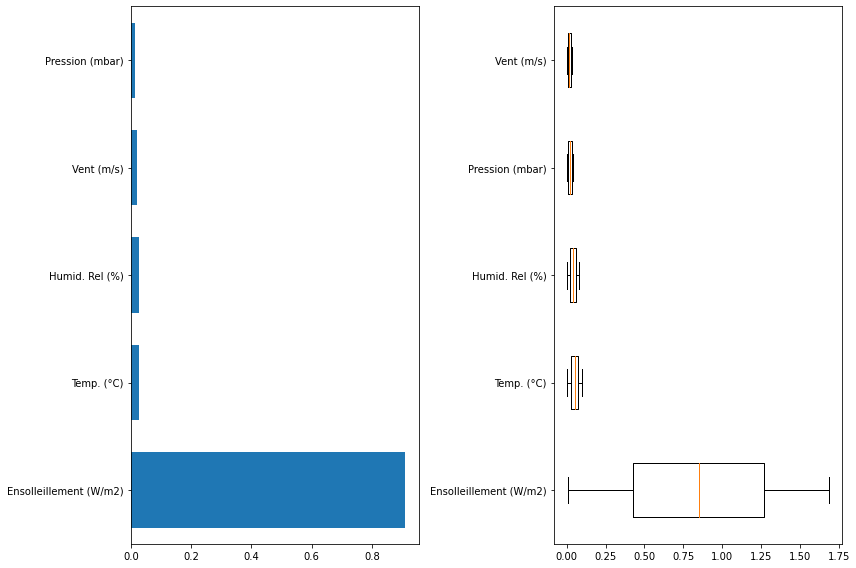

In [ ]:
feature_perm = df_perm
feature_imp = feat_imp.sort_values(['imps'],ascending=False)
feature_imp = feature_imp

tree_indices = np.arange(0, len(feature_imp)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(tree_indices,feature_imp['imps'].values, height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_imp['cols'].values)
ax1.set_ylim((0, len(feature_imp)))

ax2.boxplot(feature_perm, vert=False,labels=feature_perm.index.values)
fig.tight_layout()
plt.show()

# Sélection des variables par méthode RFE

In [ ]:
from sklearn.feature_selection import RFE

# Informations sur les données
n = 27553             # Nombre d'observations
p = 5                 # Nombre de variables
n_arbres = 500
m_try = "auto"

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=m_try, n_jobs=-1)
rfe = RFE(estimator=clf, n_features_to_select=3, step=1, verbose=1)
rfe.fit(X, tf.squeeze(np.asarray(Y),1))

Fitting estimator with 5 features.
Fitting estimator with 4 features.


RFE(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                    criterion='mse', max_depth=None,
                                    max_features='auto', max_leaf_nodes=None,
                                    max_samples=None, min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=500, n_jobs=-1, oob_score=True,
                                    random_state=None, verbose=0,
                                    warm_start=False),
    n_features_to_select=3, step=1, verbose=1)

In [ ]:
X

,Temp. (°C),Humid. Rel (%),Vent (m/s),Pression (mbar),Ensolleillement (W/m2)
Date,,,,,
2018-07-01 00:00:00,18.230667,78.229332,1.434800,930.0,0.0
2018-07-01 00:15:00,18.274668,78.177330,1.141000,930.0,0.0
2018-07-01 00:30:00,18.438667,77.388664,1.375600,930.0,0.0
2018-07-01 00:45:00,18.439333,77.211334,1.177733,930.0,0.0
2018-07-01 01:00:00,18.384001,77.567337,1.409467,930.0,0.0
...,...,...,...,...,...
2019-04-13 23:00:00,21.508667,85.333336,2.168933,929.0,0.0
2019-04-13 23:15:00,21.448000,85.680000,1.835733,929.0,0.0
2019-04-13 23:30:00,21.527334,85.346664,2.152133,929.0,0.0


In [ ]:
rfe.ranking_

array([1, 1, 2, 3, 1])

# Sélection des variables par méthode RFE-CV

In [ ]:
from sklearn.feature_selection import RFECV

# Informations sur les données
n = 27553             # Nombre d'observations
p = 5                 # Nombre de variables
n_arbres = 500
m_try = 5
min_features_to_select = 1

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features="auto", n_jobs=-1)
rfecv = RFECV(estimator=clf, step=1, cv=5, scoring='neg_mean_absolute_error',min_features_to_select=min_features_to_select, verbose=1)
rfecv.fit(X, tf.squeeze(np.asarray(Y),1))

Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.


RFECV(cv=5,
      estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                      criterion='mse', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=500, n_jobs=-1,
                                      oob_score=True, random_state=None,
                                      verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_absolute_error',
      step=1, verbose=1)

Optimal number of features : 3


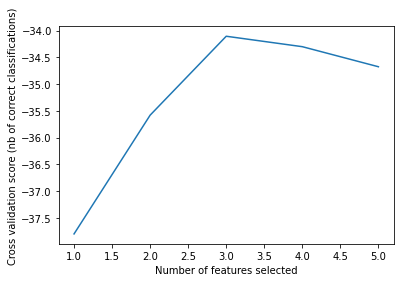

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.ranking_

array([1, 1, 2, 3, 1])

# Sélection des variables par tests de collinéarité VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#function for removing features with high vif
def drop_high_vif(X, thresh=100):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

#function for listing vif values
def vif_values(X):
    add_constant(X)
    df=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    return df


In [ ]:
X_reduit_VIF = drop_high_vif(X,thresh=20)
X_reduit_VIF

dropping 'Pression (mbar)' at index: 3
Remaining variables:
Index(['Temp. (°C)', 'Humid. Rel (%)', 'Vent (m/s)', 'Ensolleillement (W/m2)'], dtype='object')


,Temp. (°C),Humid. Rel (%),Vent (m/s),Ensolleillement (W/m2)
Date,,,,
2018-07-01 00:00:00,18.230667,78.229332,1.434800,0.0
2018-07-01 00:15:00,18.274668,78.177330,1.141000,0.0
2018-07-01 00:30:00,18.438667,77.388664,1.375600,0.0
2018-07-01 00:45:00,18.439333,77.211334,1.177733,0.0
2018-07-01 01:00:00,18.384001,77.567337,1.409467,0.0
...,...,...,...,...
2019-04-13 23:00:00,21.508667,85.333336,2.168933,0.0
2019-04-13 23:15:00,21.448000,85.680000,1.835733,0.0
2019-04-13 23:30:00,21.527334,85.346664,2.152133,0.0


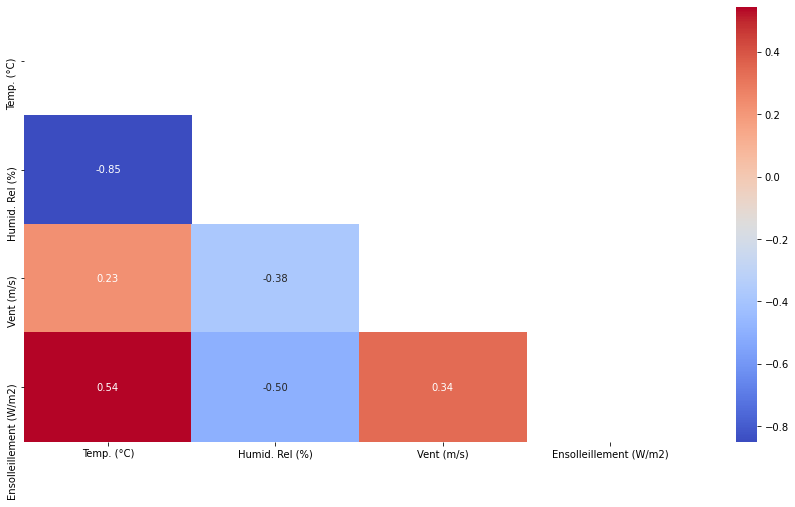

In [ ]:
import seaborn as sns

corr = X_reduit_VIF.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')